In [2]:
import pandas as pd

pd.set_option('display.max_colwidth', None, 'display.max_rows', None)

In [8]:
df = pd.read_csv('../Data/Images.csv')
df.head()

,fname,class_name,height,width,xmin,ymin,xmax,ymax
0,../Data/Images/british_shorthair/British_Shorthair_10.jpg,british_shorthair,233.0,350.0,83.0,29.0,197.0,142.0
1,../Data/Images/german_shorthaired/german_shorthaired_119.jpg,german_shorthaired,500.0,500.0,128.0,22.0,240.0,222.0
2,../Data/Images/english_setter/english_setter_158.jpg,english_setter,333.0,500.0,97.0,35.0,304.0,199.0
3,../Data/Images/siamese/Siamese_178.jpg,siamese,500.0,400.0,32.0,18.0,363.0,369.0
4,../Data/Images/pomeranian/pomeranian_162.jpg,pomeranian,222.0,300.0,19.0,32.0,123.0,129.0


In [42]:
import torch.nn as nn
from torch.utils.data import Dataset
import torch
from sklearn import preprocessing
import cv2
import matplotlib.pyplot as plt
import bounding_box.bounding_box as bb

In [11]:
encoder = preprocessing.LabelEncoder()

In [12]:
targets = encoder.fit_transform(df.class_name.values)
df['targets'] = targets
df.head()

,fname,class_name,height,width,xmin,ymin,xmax,ymax,targets
0,../Data/Images/british_shorthair/British_Shorthair_10.jpg,british_shorthair,233.0,350.0,83.0,29.0,197.0,142.0,9
1,../Data/Images/german_shorthaired/german_shorthaired_119.jpg,german_shorthaired,500.0,500.0,128.0,22.0,240.0,222.0,14
2,../Data/Images/english_setter/english_setter_158.jpg,english_setter,333.0,500.0,97.0,35.0,304.0,199.0,13
3,../Data/Images/siamese/Siamese_178.jpg,siamese,500.0,400.0,32.0,18.0,363.0,369.0,32
4,../Data/Images/pomeranian/pomeranian_162.jpg,pomeranian,222.0,300.0,19.0,32.0,123.0,129.0,24


In [78]:
class CSVDataset(Dataset):
    def __init__(self):
        self.df = df
        self.image_ids = self.df['fname'].unique()
        
    def __len__(self):
        return self.image_ids.shape[0]
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        im = cv2.cvtColor(cv2.imread(image_id), cv2.COLOR_BGR2RGB)
        
        # extract the bounding boxes
        records = self.df[self.df['fname'] == image_id]
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        class_labels = records['targets'].values
        
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['image_id'] = torch.tensor([idx])
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.as_tensor(class_labels, dtype=torch.int32)
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        #im = torch.as_tensor(im)
        
        return im, target    

In [79]:
d = CSVDataset()

In [80]:
im, target = d.__getitem__(0)

In [81]:
target, im.shape

({'image_id': tensor([0]),
  'boxes': tensor([[ 83.,  29., 197., 142.]]),
  'labels': tensor([9], dtype=torch.int32),
  'area': tensor([12882.]),
  'iscrowd': tensor([0])},
 (350, 233, 3))

In [82]:
target['boxes'], target['labels'], target['image_id'], target['area']

(tensor([[ 83.,  29., 197., 142.]]),
 tensor([9], dtype=torch.int32),
 tensor([0]),
 tensor([12882.]))

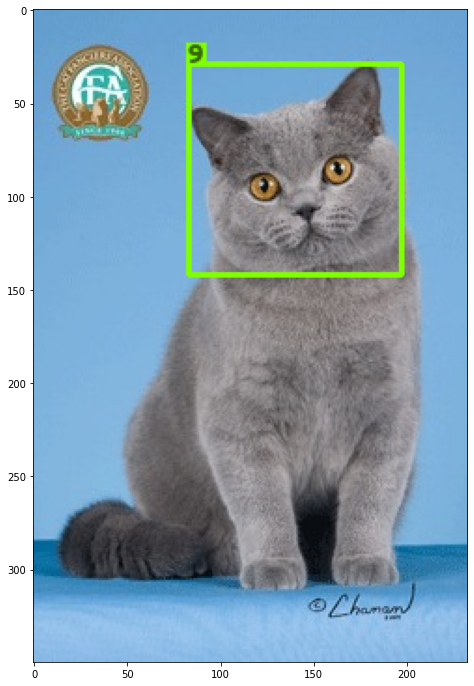

In [83]:
fig = plt.figure(figsize=(12,12))

for i in range(len(target['boxes'])):
    bb.add(
        im, 
        target['boxes'][i][0].numpy(), 
        target['boxes'][i][1].numpy(), 
        target['boxes'][i][2].numpy(), 
        target['boxes'][i][3].numpy(), 
        str(target['labels'][i].numpy()), 
    )
plt.imshow(im)

In [84]:
d.__len__()

3686